In [11]:
import numpy as np
from numpy.linalg import LinAlgError
import scipy
from scipy.optimize.linesearch import scalar_search_wolfe2
from scipy.linalg import cho_factor, cho_solve
from datetime import datetime
from collections import defaultdict

from scipy.special import expit

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Optimization

In [2]:
class LineSearchTool(object):
    """
    Line search tool for adaptively tuning the step size of the algorithm.

    method : String containing 'Wolfe', 'Armijo' or 'Constant'
        Method of tuning step-size.
        Must be be one of the following strings:
            - 'Wolfe' -- enforce strong Wolfe conditions;
            - 'Armijo" -- adaptive Armijo rule;
            - 'Constant' -- constant step size.
    kwargs :
        Additional parameters of line_search method:

        If method == 'Wolfe':
            c1, c2 : Constants for strong Wolfe conditions
            alpha_0 : Starting point for the backtracking procedure
                to be used in Armijo method in case of failure of Wolfe method.
        If method == 'Armijo':
            c1 : Constant for Armijo rule
            alpha_0 : Starting point for the backtracking procedure.
        If method == 'Constant':
            c : The step size which is returned on every step.
    """
    def __init__(self, method='Wolfe', **kwargs):
        self._method = method
        if self._method == 'Wolfe':
            self.c1 = kwargs.get('c1', 1e-4)
            self.c2 = kwargs.get('c2', 0.9)
            self.alpha_0 = kwargs.get('alpha_0', 1.0)
        elif self._method == 'Armijo':
            self.c1 = kwargs.get('c1', 1e-4)
            self.alpha_0 = kwargs.get('alpha_0', 1.0)
        elif self._method == 'Constant':
            self.c = kwargs.get('c', 1.0)
        else:
            raise ValueError('Unknown method {}'.format(method))

    @classmethod
    def from_dict(cls, options):
        if type(options) != dict:
            raise TypeError('LineSearchTool initializer must be of type dict')
        return cls(**options)

    def to_dict(self):
        return self.__dict__

    def line_search(self, oracle, x_k, d_k, previous_alpha=None):
        """
        Finds the step size alpha for a given starting point x_k
        and for a given search direction d_k that satisfies necessary
        conditions for phi(alpha) = oracle.func(x_k + alpha * d_k).

        Parameters
        ----------
        oracle : BaseSmoothOracle-descendant object
            Oracle with .func_directional() and .grad_directional() methods implemented for computing
            function values and its directional derivatives.
        x_k : np.array
            Starting point
        d_k : np.array
            Search direction
        previous_alpha : float or None
            Starting point to use instead of self.alpha_0 to keep the progress from
             previous steps. If None, self.alpha_0, is used as a starting point.

        Returns
        -------
        alpha : float or None if failure
            Chosen step size
        """
        # TODO: Implement line search procedures for Armijo, Wolfe and Constant steps.
        if self._method == 'Constant':
            return self.c
        alpha_0 = previous_alpha if previous_alpha else self.alpha_0
        phi = lambda a: oracle.func_directional(x_k, d_k, a)
        derphi = lambda a: oracle.grad_directional(x_k, d_k, a)
        c2 = self.c2 if self._method == 'Wolfe' else 0
        alpha, _, _, _ = scalar_search_wolfe2(phi=phi,
                                              derphi=derphi,
                                              phi0=phi(0),
                                              derphi0=derphi(0),
                                              c1=self.c1,
                                              c2=c2,  amax=alpha_0)
        if alpha is None:
            alpha = alpha_0
            while phi(alpha) > phi(0) + self.c1 * alpha * derphi(0):
                alpha /= 2
        return alpha

In [3]:
def get_line_search_tool(line_search_options=None):
    if line_search_options:
        if type(line_search_options) is LineSearchTool:
            return line_search_options
        else:
            return LineSearchTool.from_dict(line_search_options)
    else:
        return LineSearchTool()

In [4]:
def gradient_descent(oracle, x_0, tolerance=1e-5, max_iter=10000,
                     line_search_options=None, trace=False, display=False):
    """
    Gradien descent optimization method.

    Parameters
    ----------
    oracle : BaseSmoothOracle-descendant object
        Oracle with .func(), .grad() and .hess() methods implemented for computing
        function value, its gradient and Hessian respectively.
    x_0 : np.array
        Starting point for optimization algorithm
    tolerance : float
        Epsilon value for stopping criterion.
    max_iter : int
        Maximum number of iterations.
    line_search_options : dict, LineSearchTool or None
        Dictionary with line search options. See LineSearchTool class for details.
    trace : bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.
    display : bool
        If True, debug information is displayed during optimization.
        Printing format and is up to a student and is not checked in any way.

    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
    message : string
        "success" or the description of error:
            - 'iterations_exceeded': if after max_iter iterations of the method x_k still doesn't satisfy
                the stopping criterion.
            - 'computational_error': in case of getting Infinity or None value during the computations.
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['time'] : list of floats, containing time in seconds passed from the start of the method
            - history['func'] : list of function values f(x_k) on every step of the algorithm
            - history['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
            - history['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2

    Example:
    --------
    >> oracle = QuadraticOracle(np.eye(5), np.arange(5))
    >> x_opt, message, history = gradient_descent(oracle, np.zeros(5), line_search_options={'method': 'Armijo', 'c1': 1e-4})
    >> print('Found optimal point: {}'.format(x_opt))
       Found optimal point: [ 0.  1.  2.  3.  4.]
    """
    history = defaultdict(list) if trace else None
    line_search_tool = get_line_search_tool(line_search_options)
    x_k = np.copy(x_0)

    # TODO: Implement gradient descent
    # Use line_search_tool.line_search() for adaptive step size.
    def fill_history():
        if not trace:
            return
        history['time'].append(datetime.now() - t_0)
        history['func'].append(func_k)
        history['grad_norm'].append(grad_k_norm)
        if len(x_k) <= 2:
            history['x'].append(np.copy(x_k))

    t_0 = datetime.now()
    func_k = oracle.func(x_k)
    grad_k = oracle.grad(x_k)
    grad_0_norm = grad_k_norm = np.linalg.norm(grad_k)
    fill_history()
    if display:
        print('Begin new GD')

    for i in range(max_iter):
        if display:
            print('i = {} grad_norm = {} func = {} x = {} grad = {}'.format(i, grad_k_norm, func_k, x_k, grad_k))
        if grad_k_norm ** 2 <= tolerance * grad_0_norm ** 2:
            break

        d_k = -grad_k
        a_k = line_search_tool.line_search(oracle, x_k, d_k)
        x_k += a_k * d_k
        func_k = oracle.func(x_k)
        grad_k = oracle.grad(x_k)
        grad_k_norm = np.linalg.norm(grad_k)
        fill_history()

    if grad_k_norm ** 2 <= tolerance * grad_0_norm ** 2:
        return x_k, 'success', history
    else:
        return x_k, 'iterations_exceeded', history

In [5]:
def newton(oracle, x_0, tolerance=1e-5, max_iter=100,
           line_search_options=None, trace=False, display=False):
    """
    Newton's optimization method.

    Parameters
    ----------
    oracle : BaseSmoothOracle-descendant object
        Oracle with .func(), .grad() and .hess() methods implemented for computing
        function value, its gradient and Hessian respectively. If the Hessian
        returned by the oracle is not positive-definite method stops with message="newton_direction_error"
    x_0 : np.array
        Starting point for optimization algorithm
    tolerance : float
        Epsilon value for stopping criterion.
    max_iter : int
        Maximum number of iterations.
    line_search_options : dict, LineSearchTool or None
        Dictionary with line search options. See LineSearchTool class for details.
    trace : bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.
    display : bool
        If True, debug information is displayed during optimization.

    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
    message : string
        'success' or the description of error:
            - 'iterations_exceeded': if after max_iter iterations of the method x_k still doesn't satisfy
                the stopping criterion.
            - 'newton_direction_error': in case of failure of solving linear system with Hessian matrix (e.g. non-invertible matrix).
            - 'computational_error': in case of getting Infinity or None value during the computations.
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['time'] : list of floats, containing time passed from the start of the method
            - history['func'] : list of function values f(x_k) on every step of the algorithm
            - history['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
            - history['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2

    Example:
    --------
    >> oracle = QuadraticOracle(np.eye(5), np.arange(5))
    >> x_opt, message, history = newton(oracle, np.zeros(5), line_search_options={'method': 'Constant', 'c': 1.0})
    >> print('Found optimal point: {}'.format(x_opt))
       Found optimal point: [ 0.  1.  2.  3.  4.]
    """
    history = defaultdict(list) if trace else None
    line_search_tool = get_line_search_tool(line_search_options)
    x_k = np.copy(x_0)

    # TODO: Implement Newton's method.
    # Use line_search_tool.line_search() for adaptive step size.
    def fill_history():
        if not trace:
            return
        history['time'].append(datetime.now() - t_0)
        history['func'].append(func_k)
        history['grad_norm'].append(grad_k_norm)
        if len(x_k) <= 2:
            history['x'].append(np.copy(x_k))

    t_0 = datetime.now()
    func_k = oracle.func(x_k)
    grad_k = oracle.grad(x_k)
    hess_k = oracle.hess(x_k)
    grad_0_norm = grad_k_norm = np.linalg.norm(grad_k)
    fill_history()
    if display:
        print('Begin new NM')

    for i in range(max_iter):
        if display:
            print('i = {} grad_norm = {} func = {} x = {} grad = {}'.format(i, grad_k_norm, func_k, x_k, grad_k))
        if grad_k_norm ** 2 <= tolerance * grad_0_norm ** 2:
            break
        try:
            d_k = cho_solve(cho_factor(hess_k), -grad_k)
        except LinAlgError:
            return x_k, 'computational_error', history
        a_k = line_search_tool.line_search(oracle, x_k, d_k)
        x_k += a_k * d_k
        func_k = oracle.func(x_k)
        grad_k = oracle.grad(x_k)
        hess_k = oracle.hess(x_k)
        grad_k_norm = np.linalg.norm(grad_k)
        fill_history()

    if grad_k_norm ** 2 <= tolerance * grad_0_norm ** 2:
        return x_k, 'success', history
    else:
        return x_k, 'iterations_exceeded', history

# Oracles

In [7]:
class BaseSmoothOracle(object):
    """
    Base class for implementation of oracles.
    """
    def func(self, x):
        """
        Computes the value of function at point x.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, x):
        """
        Computes the gradient at point x.
        """
        raise NotImplementedError('Grad oracle is not implemented.')
    
    def hess(self, x):
        """
        Computes the Hessian matrix at point x.
        """
        raise NotImplementedError('Hessian oracle is not implemented.')
    
    def func_directional(self, x, d, alpha):
        """
        Computes phi(alpha) = f(x + alpha*d).
        """
        return np.squeeze(self.func(x + alpha * d))

    def grad_directional(self, x, d, alpha):
        """
        Computes phi'(alpha) = (f(x + alpha*d))'_{alpha}
        """
        return np.squeeze(self.grad(x + alpha * d).dot(d))

In [8]:
class QuadraticOracle(BaseSmoothOracle):
    """
    Oracle for quadratic function:
       func(x) = 1/2 x^TAx - b^Tx.
    """

    def __init__(self, A, b):
        if not scipy.sparse.isspmatrix_dia(A) and not np.allclose(A, A.T):
            raise ValueError('A should be a symmetric matrix.')
        self.A = A
        self.b = b

    def func(self, x):
        return 0.5 * np.dot(self.A.dot(x), x) - self.b.dot(x)

    def grad(self, x):
        return self.A.dot(x) - self.b

    def hess(self, x):
        return self.A 

In [9]:
class LogRegL2Oracle(BaseSmoothOracle):
    """
    Oracle for logistic regression with l2 regularization:
         func(x) = 1/m sum_i log(1 + exp(-b_i * a_i^T x)) + regcoef / 2 ||x||_2^2.

    Let A and b be parameters of the logistic regression (feature matrix
    and labels vector respectively).
    For user-friendly interface use create_log_reg_oracle()

    Parameters
    ----------
        matvec_Ax : function
            Computes matrix-vector product Ax, where x is a vector of size n.
        matvec_ATx : function of x
            Computes matrix-vector product A^Tx, where x is a vector of size m.
        matmat_ATsA : function
            Computes matrix-matrix-matrix product A^T * Diag(s) * A,
    """
    def __init__(self, matvec_Ax, matvec_ATx, matmat_ATsA, b, regcoef):
        self.matvec_Ax = matvec_Ax
        self.matvec_ATx = matvec_ATx
        self.matmat_ATsA = matmat_ATsA
        self.b = b
        self.m = len(b)
        self.regcoef = regcoef

    def func(self, x):
        func = np.logaddexp(0, -self.b * self.matvec_Ax(x)).mean() + self.regcoef * (x @ x) / 2
        return func

    def grad(self, x):
        expit_curr = expit(-self.b * self.matvec_Ax(x))
        grad = -self.matvec_ATx(self.b * expit_curr) / self.m + self.regcoef * x
        return grad

    def hess(self, x):
        expit_curr = expit(-self.b @ self.matvec_Ax(x))
        n = len(x)
        ones = np.array([1] * self.m)
        hess = expit_curr * (1 - expit_curr) * self.matmat_ATsA(ones) / self.m + self.regcoef * np.eye(n)
        return hess

In [10]:
def create_log_reg_oracle(A, b, regcoef, oracle_type='usual'):
    """
    Auxiliary function for creating logistic regression oracles.
        `oracle_type` must be either 'usual' or 'optimized'
    """
    matvec_Ax = lambda x: A @ x  # TODO: Implement
    matvec_ATx = lambda x: A.T @ x  # TODO: Implement

    def matmat_ATsA(s):
        # TODO: Implement
        return A.T @ np.diag(s) @ A

    if oracle_type == 'usual':
        oracle = LogRegL2Oracle
    elif oracle_type == 'optimized':
        oracle = LogRegL2OptimizedOracle
    else:
        raise 'Unknown oracle_type=%s' % oracle_type
    return oracle(matvec_Ax, matvec_ATx, matmat_ATsA, b, regcoef)

# Plot trajectory 2d

In [12]:
def plot_levels(func, xrange=None, yrange=None, levels=None, save=None):
    """
    Plotting the contour lines of the function.

    Example:
    --------
    >> oracle = oracles.QuadraticOracle(np.array([[1.0, 2.0], [2.0, 5.0]]), np.zeros(2))
    >> plot_levels(oracle.func)
    """
    if xrange is None:
        xrange = [-6, 6]
    if yrange is None:
        yrange = [-5, 5]
    if levels is None:
        levels = [0, 0.25, 1, 4, 9, 16, 25]
        
    x = np.linspace(xrange[0], xrange[1], 100)
    y = np.linspace(yrange[0], yrange[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))

    CS = plt.contour(X, Y, Z, levels=levels, colors='k', linewidth=4.0)
    plt.clabel(CS, inline=1, fontsize=8) 
    plt.grid()
    if save:
        plt.savefig(save + '.png')


In [15]:
def plot_trajectory(func, history, fit_axis=False, label=None, save=None):
    """
    Plotting the trajectory of a method. 
    Use after plot_levels(...).

    Example:
    --------
    >> oracle = oracles.QuadraticOracle(np.array([[1.0, 2.0], [2.0, 5.0]]), np.zeros(2))
    >> [x_star, msg, history] = optimization.gradient_descent(oracle, np.array([3.0, 1.5], trace=True)
    >> plot_levels(oracle.func)
    >> plot_trajectory(oracle.func, history['x'])
    """
    x_values, y_values = zip(*history)
    plt.plot(x_values, y_values, '-v', linewidth=2.0, ms=4.0,
             alpha=1.0, c='r', label=label)
    
    # Tries to adapt axis-ranges for the trajectory:
    if fit_axis:
        xmax, ymax = np.max(x_values), np.max(y_values)
        COEF = 1.5
        xrange = [-xmax * COEF, xmax * COEF]
        yrange = [-ymax * COEF, ymax * COEF]
        plt.xlim(xrange)
        plt.ylim(yrange)
    if save:
        plt.show()
        #plt.savefig(save + '.png')

/home/dima/.local/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


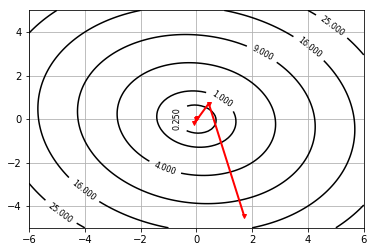

cond = 1.295, j = 0, method = Wolfe, steps = 5, x[4] = [-0.00446753 -0.01081078]


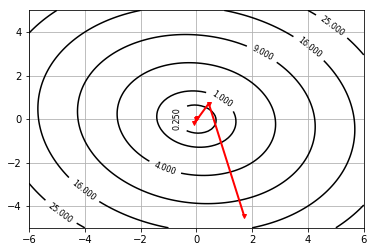

cond = 1.295, j = 0, method = Armijo, steps = 5, x[4] = [-0.00446753 -0.01081078]


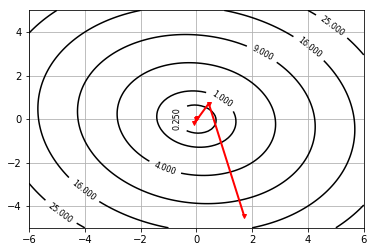

cond = 1.295, j = 0, method = Constant, steps = 5, x[4] = [-0.00446753 -0.01081078]


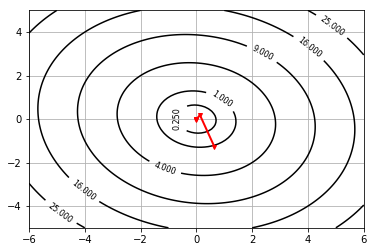

cond = 1.295, j = 1, method = Wolfe, steps = 5, x[4] = [-0.00120057 -0.00290677]


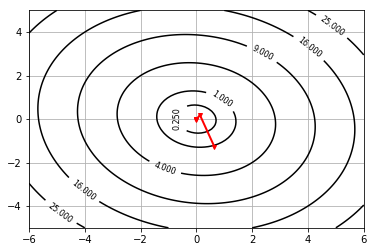

cond = 1.295, j = 1, method = Armijo, steps = 5, x[4] = [-0.00120057 -0.00290677]


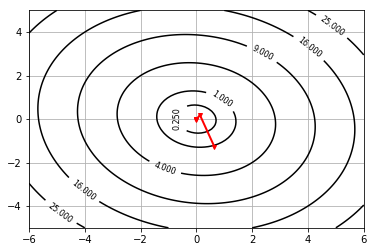

cond = 1.295, j = 1, method = Constant, steps = 5, x[4] = [-0.00120057 -0.00290677]


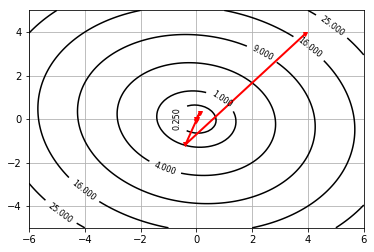

cond = 1.295, j = 2, method = Wolfe, steps = 6, x[4] = [0.0066178  0.01596067]


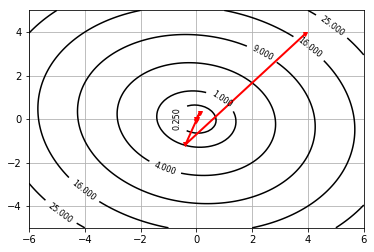

cond = 1.295, j = 2, method = Armijo, steps = 6, x[4] = [0.0066178  0.01596067]


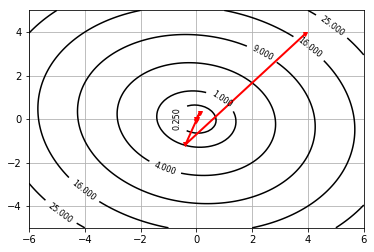

cond = 1.295, j = 2, method = Constant, steps = 6, x[4] = [0.0066178  0.01596067]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:421: LineSearchWarning: The line search algorithm could not find a solution less than or equal to amax: 1.0
  warn(msg, LineSearchWarning)


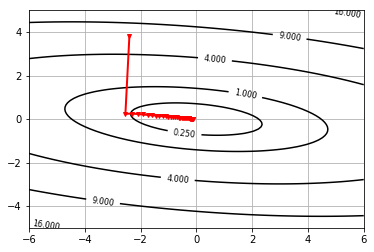

cond = 11.356, j = 0, method = Wolfe, steps = 35, x[4] = [-1.91920371  0.21067532]


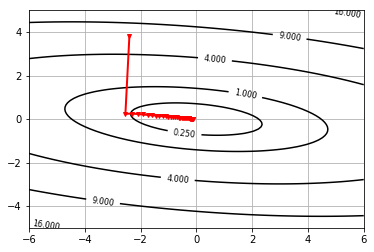

cond = 11.356, j = 0, method = Armijo, steps = 35, x[4] = [-1.91920371  0.21067532]


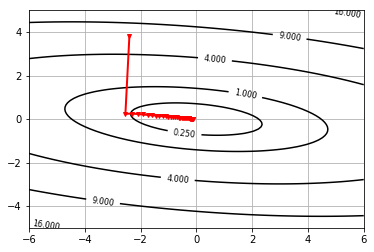

cond = 11.356, j = 0, method = Constant, steps = 35, x[4] = [-1.91920371  0.21067532]


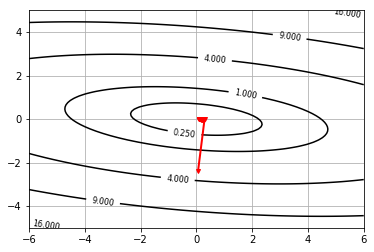

cond = 11.356, j = 1, method = Wolfe, steps = 16, x[4] = [ 0.21983148 -0.02413143]


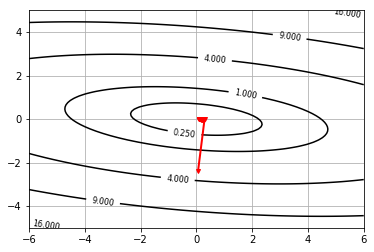

cond = 11.356, j = 1, method = Armijo, steps = 16, x[4] = [ 0.21983148 -0.02413143]


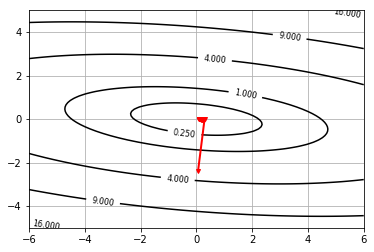

cond = 11.356, j = 1, method = Constant, steps = 16, x[4] = [ 0.21983148 -0.02413143]


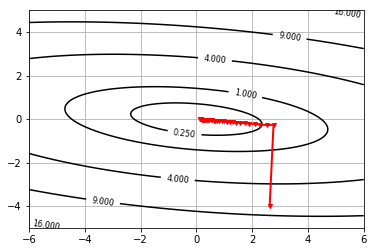

cond = 11.356, j = 2, method = Wolfe, steps = 35, x[4] = [ 2.0876119  -0.22916187]


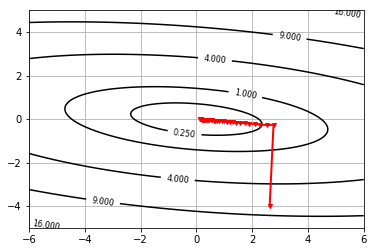

cond = 11.356, j = 2, method = Armijo, steps = 35, x[4] = [ 2.0876119  -0.22916187]


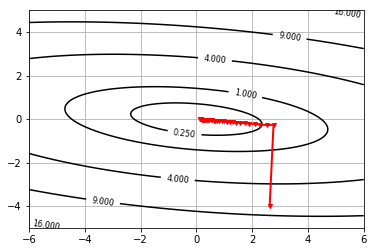

cond = 11.356, j = 2, method = Constant, steps = 35, x[4] = [ 2.0876119  -0.22916187]


In [16]:
A_good = np.array([
        [1, 0.1],
        [0.1, 1.2]
])
#b_1 = np.random.uniform(0, 10, 2)
A_bad = np.array([
    [0.1, 0.1],
    [0.1, 1]
])
#b_2 = np.random.uniform(0, 10, 2)

for i, A in enumerate([A_good, A_bad]):
    cond = np.linalg.cond(A)
    oracle  = QuadraticOracle(A, np.zeros(2))
    x_0_s = [np.random.uniform(-5, 5, size=2) for _ in range(3)]
    for j in range(3):
        x_0 = x_0_s[j]
        for method in ['Wolfe', 'Armijo', 'Constant']:
            [x_star, msg, history] = gradient_descent(oracle, x_0,
                                                      line_search_options={'method' : method},
                                                      trace=True)
            plt.figure()
            plot_levels(oracle.func)
            name = 'experiment_1/{}-{}-{}'.format(round(cond, 3), method, j)
            plot_trajectory(oracle.func, history['x'], save=name)
            print('cond = {}, j = {}, method = {}, steps = {}, x[4] = {}'.format(round(cond,3), j, method, len(history['x']), history['x'][4]))


In [20]:
x = np.arange(0, 4, .1)

In [21]:
y = x ** 2
y

array([0.000e+00, 1.000e-02, 4.000e-02, 9.000e-02, 1.600e-01, 2.500e-01,
       3.600e-01, 4.900e-01, 6.400e-01, 8.100e-01, 1.000e+00, 1.210e+00,
       1.440e+00, 1.690e+00, 1.960e+00, 2.250e+00, 2.560e+00, 2.890e+00,
       3.240e+00, 3.610e+00, 4.000e+00, 4.410e+00, 4.840e+00, 5.290e+00,
       5.760e+00, 6.250e+00, 6.760e+00, 7.290e+00, 7.840e+00, 8.410e+00,
       9.000e+00, 9.610e+00, 1.024e+01, 1.089e+01, 1.156e+01, 1.225e+01,
       1.296e+01, 1.369e+01, 1.444e+01, 1.521e+01])

Text(0.5,0,'$\\ae$')

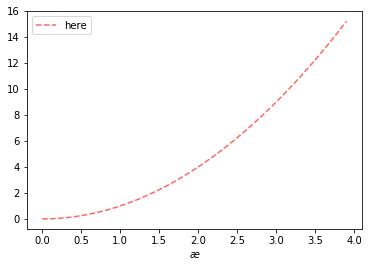

In [35]:
plt.plot(x, y, ls='--', color='r', alpha=0.6, label='here')
plt.legend()
plt.xlabel(r'$\ae$')

In [41]:
a = list(range(1, 4))

In [42]:
from scipy.sparse import diags

In [43]:
diags(a).toarray()

array([[1., 0., 0.],
       [0., 2., 0.],
       [0., 0., 3.]])

In [45]:
b = np.array([1, 2, 3])

In [48]:
diags(a) * b

array([1., 4., 9.])

In [55]:
np.random.multivariate_normal(np.zeros(3), np.eye(3))

array([-0.00653703, -0.15933246, -0.4968971 ])

In [50]:
np.zeros(3)

array([0., 0., 0.])

In [1]:
from sklearn.datasets import load_svmlight_file

In [2]:
data = load_svmlight_file('experiment_3/datasets/w8a.t')

In [21]:
data[0].shape

(49749, 300)

In [11]:
data[0].T @ data[0]

<300x300 sparse matrix of type '<class 'numpy.float64'>'
	with 47250 stored elements in Compressed Sparse Column format>

In [19]:
a, = data[1].shape

In [20]:
a

49749

In [22]:
from datetime import datetime

In [23]:
t0 = datetime.now()

In [24]:
t1 = datetime.now() - t0

In [29]:
t1.total_seconds()

11.623032